# **Multiclass Classification**

In [38]:
import os
import sys
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

torch.backends.cudnn.deterministic = True

In [19]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

Platform: win32
Python version: 3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]
---
matplotlib version: 3.8.3
pandas version: 2.2.0
PIL version: 10.2.0
torch version: 2.5.1+cpu
torchvision version: 0.20.1+cpu


In [20]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


**Project Goal**: To build and train a convolutional neural network, and use it to get predictions for the animal classes.

**Objectives**

- Read in data with multiple classes.
- Normalize data to improve performance.
- Create a CNN that works well with images.
- Train that network to do multiclass classification.
- Reformat the network predictions to complete the [competition](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/). - The goal of the competition is to build a model that takes an image and classifies what animal is in it. 

**1. Reading Files**

- Converting any grayscale images to RGB format with a custom class.

In [21]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

- Using transformers to resize the images, and converting the images to a Tensor of pixel values:

In [22]:
transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

- Import data:

In [33]:
data_dir = ("data_p1/data_multiclass")
train_dir = os.path.join(data_dir, "train")

print("Will read data from", train_dir)

Will read data from data_p1/data_multiclass\train


In [34]:
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

In [35]:
print("Classes:")
print(dataset.classes)
print(f"That's {len(dataset.classes)} classes")
print()
print("Tensor shape for one image:")
print(dataset[0][0].shape)

Classes:
['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']
That's 8 classes

Tensor shape for one image:
torch.Size([3, 224, 224])


- When we loop over this loader, it'll produce small batches of our images.

In [39]:
batch_size = 32
dataset_loader = DataLoader(dataset, batch_size=batch_size)

# Get one batch
first_batch = next(iter(dataset_loader))

print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])
Shape of labels: torch.Size([32])


**2. Preparing Data**

Mean and std

In [40]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [41]:
mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Computing mean and std:   0%|          | 0/95 [00:00<?, ?it/s]

Mean: tensor([0.4764, 0.4895, 0.4805])
Standard deviation: tensor([0.2511, 0.2444, 0.2472])


Normalize

In [43]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]
)

Make new normalized dataset using ImageFolder and a new DataLoader:

In [44]:
norm_dataset =datasets.ImageFolder(root=train_dir, transform=transform_norm)

norm_loader = DataLoader(dataset=norm_dataset, batch_size=32)

In [45]:
norm_mean, norm_std = get_mean_std(norm_loader)

print(f"Mean: {norm_mean}")
print(f"Standard deviation: {norm_std}")

Computing mean and std:   0%|          | 0/95 [00:00<?, ?it/s]

Mean: tensor([-3.3159e-07,  3.5433e-07, -4.4405e-07])
Standard deviation: tensor([1.0000, 1.0000, 1.0000])


**3. Train and validation splitting**

In [46]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(norm_dataset, [0.8, 0.2])

length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset = len(norm_dataset)
percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.0% of full data
Validation data is 20.0% of full data


Visualize train and test sets:

In [47]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

In [48]:
train_class_distributions = class_counts(train_dataset)

train_class_distributions

  0%|          | 0/2420 [00:00<?, ?it/s]

antelope_duiker     364
bird                254
blank               334
civet_genet         364
hog                 131
leopard             318
monkey_prosimian    356
rodent              299
dtype: int64

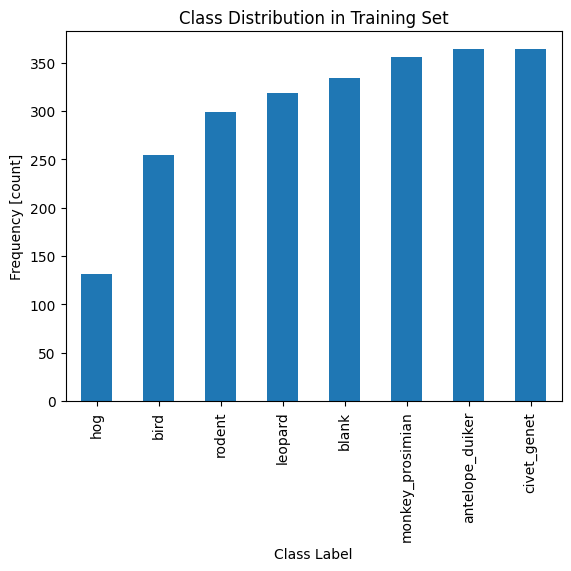

In [49]:
# Create a bar plot from train_class_distribution
train_class_distributions.sort_values().plot(kind="bar")

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Training Set");

  0%|          | 0/605 [00:00<?, ?it/s]

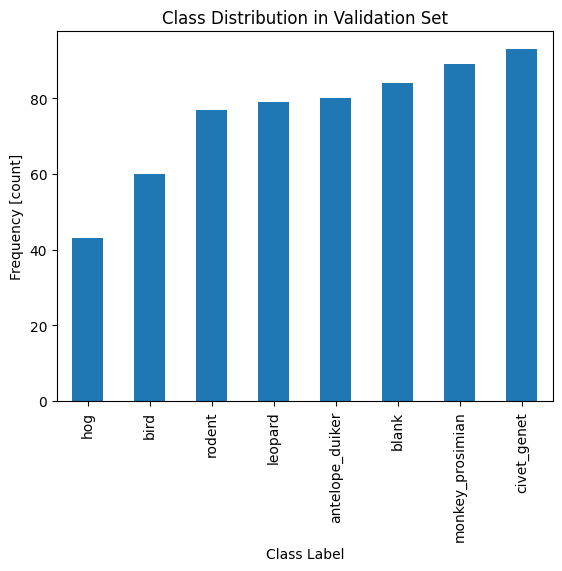

In [50]:
# Get the class distribution
validation_class_distributions = class_counts(val_dataset)

# Create a bar plot from train_class_distribution
validation_class_distributions.sort_values().plot(kind="bar")

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Validation Set");

Data Loaders Initialization